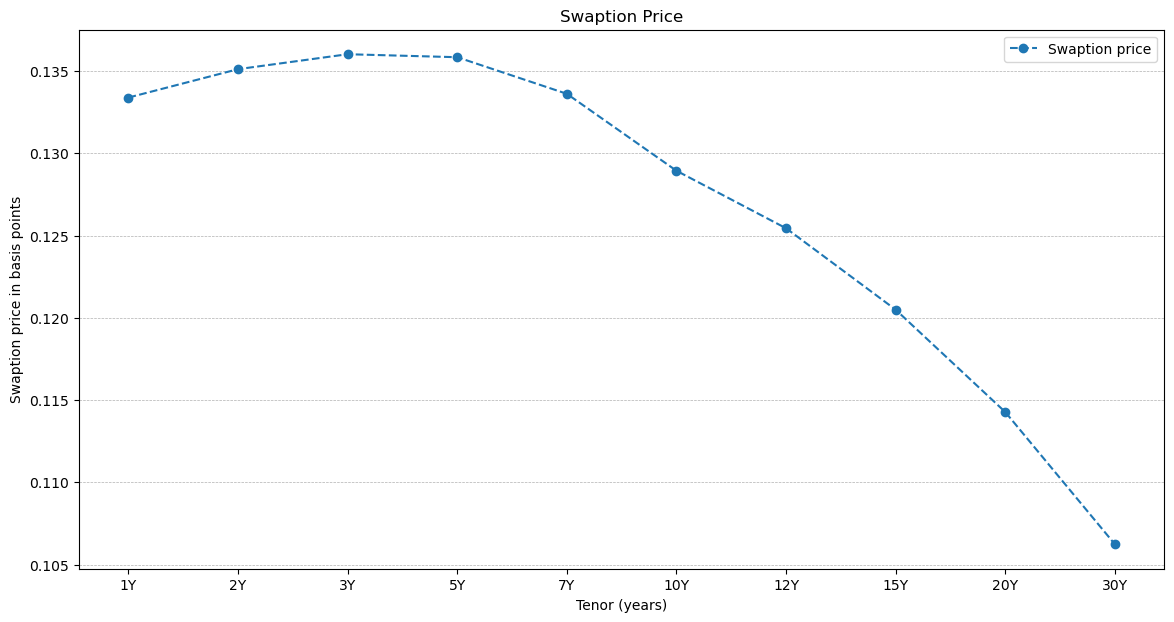

In [12]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

def sabr_volatility(F, K, T, alpha, beta, rho, nu):
    """
    Calculate the SABR model implied volatility.
    """
    if F == K:
        FK_beta = (F * K) ** ((1 - beta) / 2)
        z = nu / alpha * FK_beta * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
    else:
        FK_beta = (F * K) ** ((1 - beta) / 2)
        z = nu / alpha * FK_beta * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))

    sigma = (alpha / (FK_beta * (1 + ((1 - beta) ** 2 / 24) * np.log(F / K) ** 2 + 
             ((1 - beta) ** 4 / 1920) * np.log(F / K) ** 4))) * (z / x_z)
    return sigma

def black_formula(F, K, sigma, T, is_call=True):
    """
    Black's formula for pricing European options on futures.
    """
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if is_call:
        price = np.exp(-T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        price = np.exp(-T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    
    return price

def calculate_prices(tenors_data, T):
    prices = {}
    for tenor, (F, sigma) in tenors_data.items():
        price = black_formula(F, F, sigma, T, is_call=True) * 10000
        prices[tenor] = price
    return prices

def plot_prices(tenors, prices):
    plt.figure(figsize=(14, 7))
    plt.plot(tenors, prices, linestyle='--', color='tab:blue', marker='o', label='Swaption price')
    plt.xlabel('Tenor (years)')
    plt.ylabel('Swaption price in basis points')
    plt.title('Swaption Price')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/swaption_price_atm.png")
    plt.show()
    plt.close()

# Data preparation
tenors_data = {
    '1Y': (0.2938, 5.3399),
    '2Y': (0.2976, 5.3311),
    '3Y': (0.2996, 5.2101),
    '5Y': (0.2992, 5.0614),
    '7Y': (0.2943, 4.9531),
    '10Y': (0.2840, 4.8315),
    '12Y': (0.2763, 4.6781),
    '15Y': (0.2654, 4.5247),
    '20Y': (0.2517, 4.3559),
    '30Y': (0.2340, 4.1757)
}
T = 10

# Calculation
prices = calculate_prices(tenors_data, T)

# Plotting
plot_prices(list(tenors_data.keys()), list(prices.values()))



In [15]:
formatted_data = {key: f"{value:.4f}" for key, value in prices.items()}
df = pd.DataFrame(list(formatted_data.items()), columns=['Expiry x Tenor', 'Swaption price in basis points'])
df

,Expiry x Tenor,Swaption price in basis points
0,1Y,0.1334
1,2Y,0.1351
2,3Y,0.1360
3,5Y,0.1358
4,7Y,0.1336
5,10Y,0.1289
6,12Y,0.1254
7,15Y,0.1205
8,20Y,0.1143
9,30Y,0.1062
